In [ ]:
!pip install -U flwr["simulation"]==1.9.0 torch torchvision GPUtil

In [1]:
from collections import OrderedDict
from typing import Dict, List, Optional, Tuple, NamedTuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.datasets import CIFAR100
import time
import flwr as fl
from scipy import stats as st
import json

DEVICE = torch.device("cuda")  # Try "cuda" to train on GPU
print(
    f"Training on {DEVICE} using PyTorch {torch.__version__} and Flower {fl.__version__}"
)

Training on cuda using PyTorch 2.3.1 and Flower 1.9.0


In [2]:
from logging import INFO, DEBUG
from flwr.common.logger import log

In [3]:
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
def printm():
   process = psutil.Process(os.getpid())
   print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
   print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))
printm()

Gen RAM Free: 118.2 GB  | Proc size: 515.0 MB
GPU RAM Free: 15301MB | Used: 869MB | Util   5% | Total 16376MB


In [5]:
NUM_CLIENTS = 10


def load_datasets(num_clients: int):
    # Download and transform CIFAR-10 (train and test)
    transform = transforms.Compose(
        [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
    )
    trainset = CIFAR100("./dataset", train=True, download=True, transform=transform)
    testset = CIFAR100("./dataset", train=False, download=True, transform=transform)

    # Split training set into `num_clients` partitions to simulate different local datasets
    partition_size = len(trainset) // num_clients
    lengths = [partition_size] * num_clients
    datasets = random_split(trainset, lengths, torch.Generator().manual_seed(42))

    # Split each partition into train/val and create DataLoader
    trainloaders = []
    valloaders = []
    for ds in datasets:
        len_val = len(ds) // 10  # 10 % validation set
        len_train = len(ds) - len_val
        lengths = [len_train, len_val]
        ds_train, ds_val = random_split(ds, lengths, torch.Generator().manual_seed(42))
        trainloaders.append(DataLoader(ds_train, batch_size=32, shuffle=True))
        valloaders.append(DataLoader(ds_val, batch_size=32))
    testloader = DataLoader(testset, batch_size=32)
    return trainloaders, valloaders, testloader


trainloaders, valloaders, testloader = load_datasets(NUM_CLIENTS)

Files already downloaded and verified
Files already downloaded and verified


In [6]:
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 100)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x


def get_parameters(net) -> List[np.ndarray]:
    return [val.cpu().numpy() for _, val in net.state_dict().items()]


def set_parameters(net, parameters: List[np.ndarray]):
    params_dict = zip(net.state_dict().keys(), parameters)
    state_dict = OrderedDict({k: torch.Tensor(v) for k, v in params_dict})
    net.load_state_dict(state_dict, strict=True)


class ClientMetrics(NamedTuple):
    epoch: int
    loss: float
    accuracy: float
    round: int = 0
    cid: int = 0

def train(net, trainloader, epochs: int):
    """Train the network on the training set."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(net.parameters())
    net.train()
    metrics = []
    for epoch in range(epochs):  # Use the passed 'epochs' variable here
        correct, total, epoch_loss = 0, 0, 0.0
        for images, labels in trainloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            optimizer.zero_grad()
            outputs = net(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            # Metrics
            epoch_loss += loss.item()  # Make sure to call .item() to get the scalar value
            total += labels.size(0)
            correct += (torch.max(outputs.data, 1)[1] == labels).sum().item()
        epoch_loss /= len(trainloader.dataset)
        epoch_acc = correct / total
        metrics.append(ClientMetrics(epoch, epoch_loss, epoch_acc))
        print(f"Epoch {epoch}: train loss {epoch_loss:.6f}, accuracy {epoch_acc:.6f}")
    return metrics


def test(net, testloader):
    """Evaluate the network on the entire test set."""
    criterion = torch.nn.CrossEntropyLoss()
    correct, total, loss = 0, 0, 0.0
    net.eval()
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = net(images)
            loss += criterion(outputs, labels).item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    loss /= len(testloader.dataset)
    accuracy = correct / total
    return loss, accuracy

In [7]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        epochs = config.get("epochs", 1)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs)
        training_time = time.time() - start_time  # Calculate duration
        print(f"Training time for Client {self.cid}: {training_time:.2f} seconds")
        
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}



    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE)
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [8]:
from typing import Callable, Union

from flwr.common import (
    EvaluateIns,
    EvaluateRes,
    FitIns,
    FitRes,
    MetricsAggregationFn,
    NDArrays,
    Parameters,
    Scalar,
    ndarrays_to_parameters,
    parameters_to_ndarrays,
)
from flwr.server.client_manager import ClientManager
from flwr.server.client_proxy import ClientProxy
from flwr.server.strategy.aggregate import aggregate, weighted_loss_avg


class FedCustom(fl.server.strategy.Strategy):
    def __init__(
        self,
        fraction_fit: float = 1.0,
        fraction_evaluate: float = 1.0,
        min_fit_clients: int = 2,
        min_evaluate_clients: int = 2,
        min_available_clients: int = 2,
    ) -> None:
        super().__init__()
        self.fraction_fit = fraction_fit
        self.fraction_evaluate = fraction_evaluate
        self.min_fit_clients = min_fit_clients
        self.min_evaluate_clients = min_evaluate_clients
        self.min_available_clients = min_available_clients
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}
    def __repr__(self) -> str:
        return "FedCustom"

    def initialize_parameters(
        self, client_manager: ClientManager
    ) -> Optional[Parameters]:
        """Initialize global model parameters."""
        net = Net()
        ndarrays = get_parameters(net)
        return fl.common.ndarrays_to_parameters(ndarrays)

    def configure_fit(self, server_round: int, parameters: Parameters, client_manager: ClientManager):
        sample_size, min_num_clients = self.num_fit_clients(client_manager.num_available())
        clients = client_manager.sample(num_clients=sample_size, min_num_clients=min_num_clients)
        epochs_sc = 10
        

        standard_config = {"lr": 0.001, "epochs": epochs_sc}
        
        fit_configurations = []
        mode_time = []
        
        for client in clients:
            last_time = self.client_training_times.get(client.cid, [0,])[-1] # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is ths last time not a fantasy {last_time}and {client.cid}habhhahah")
            
            
            mode_time.append(round(last_time,2))
            print(f"this is tehb mode time {mode_time}")
           

        modest_value = st.mode(np.array(mode_time))
        print(f"Yeh h modest valueueueueu{modest_value}")
        print(f"yeh h server round {server_round}")
        min_value, max_value= np.min(modest_value),np.max(modest_value)
        print(f"this is the min value {min_value} and this is the max value {max_value}")
      
        
        if min_value == max_value:
            epochs_hl = epochs_sc   
        else:
            epochs_hl = int(np.floor((max_value-min_value)/max_value * epochs_sc)) 

        higher_lr_config = {"lr": 0.0001, "epochs": epochs_hl}
        print(f"The epochs for the higher lr is {epochs_hl} and the epochs for the standard lr is {epochs_sc}")




        for client in clients:
            # Choose config based on the previous training time
            last_time = self.client_training_times.get(client.cid, [0,])[-1]  # Default to 0 if no time recorded # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            print(f"This is the last time {last_time}")
            


            config_to_use = standard_config if last_time < modest_value.mode else higher_lr_config
            fit_configurations.append((client, FitIns(parameters, config_to_use)))

        return fit_configurations
    
    def parse_metrics(self, cid: int, server_round: int, metrics: str): # this function has been added to parse the metrics from the client
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            # Update training times for each client
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0)) # Yash has changed this as we now save last time of all epochs as key: value - cid: list of times
            self.parse_metrics(client.cid,server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated


    def configure_evaluate(
        self, server_round: int, parameters: Parameters, client_manager: ClientManager
    ) -> List[Tuple[ClientProxy, EvaluateIns]]:
        """Configure the next round of evaluation."""
        if self.fraction_evaluate == 0.0:
            return []
        config = {}
        evaluate_ins = EvaluateIns(parameters, config)

        # Sample clients
        sample_size, min_num_clients = self.num_evaluation_clients(
            client_manager.num_available()
        )
        clients = client_manager.sample(
            num_clients=sample_size, min_num_clients=min_num_clients
        )

        # Return client/config pairs
        return [(client, evaluate_ins) for client in clients]

    def aggregate_evaluate(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, EvaluateRes]],
        failures: List[Union[Tuple[ClientProxy, EvaluateRes], BaseException]],
    ) -> Tuple[Optional[float], Dict[str, Scalar]]:
        """Aggregate evaluation losses using weighted average."""

        if not results:
            return None, {}

        loss_aggregated = weighted_loss_avg(
            [
                (evaluate_res.num_examples, evaluate_res.loss)
                for _, evaluate_res in results
            ]
        )
        metrics_aggregated = {}
        return loss_aggregated, metrics_aggregated

    def evaluate(
        self, server_round: int, parameters: Parameters
    ) -> Optional[Tuple[float, Dict[str, Scalar]]]:
        """Evaluate global model parameters using an evalua
        tion function."""

        # Let's assume we won't perform the global model evaluation on the server side.
        
        return None

    def num_fit_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Return sample size and required number of clients."""
        num_clients = int(num_available_clients * self.fraction_fit)
        return max(num_clients, self.min_fit_clients), self.min_available_clients

    def num_evaluation_clients(self, num_available_clients: int) -> Tuple[int, int]:
        """Use a fraction of available clients for evaluation."""
        num_clients = int(num_available_clients * self.fraction_evaluate)
        return max(num_clients, self.min_evaluate_clients), self.min_available_clients

In [9]:
if DEVICE.type == "cuda":
    # Use a single client to train the global model
    client_resources = {"num_gpus": .125, "num_cpus": 1} 

In [10]:
strategy = FedCustom()
#fl.common.logger.configure(identifier="myflExpMY", filename="FLLOG_my.txt")
history = fl.simulation.start_simulation(client_fn=client_fn,
                                         num_clients=10,
                                         config=fl.server.ServerConfig(num_rounds=10),
                                         strategy=strategy,  # <-- pass the new strategy here
                                         client_resources=client_resources,

)
history


INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-25 18:21:08,248	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'memory': 72352429466.0, 'node:127.0.0.1': 1.0, 'accelerator_type:RTX': 1.0, 'GPU': 1.0, 'object_store_memory': 35293898342.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Using initial global parameters provided by strategy
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 0and 3habhhahah
this is tehb mode time [0]
This is ths last time not a fantasy 0and 9habhhahah
this is tehb mode time [0, 0]
This is ths last time not a fantasy 0and 8habhhahah
this is tehb mode time [0, 0, 0]
This is ths last time not a fantasy 0and 0habhhahah
this is tehb mode time [0, 0, 0, 0]
This is ths last time not a fantasy 0and 1habhhahah
this is tehb mode time [0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 2habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 6habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 7habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 5habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0]
This is ths last time not a fantasy 0and 4habhhahah
this is tehb mode time [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]
Yeh h modest valueueueueuModeResult(mode=0, count=10)
yeh h server round 1


INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=15356) Epoch 9: train loss 0.101422, accuracy 0.192667 [repeated 4x across cluster]
(ClientAppActor pid=15356) [Client 5] evaluate, config: {}
(ClientAppActor pid=15356) Training time for Client 4: 24.84 seconds
(ClientAppActor pid=22600) [Client 7] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.901556968688965and 6habhhahah
this is tehb mode time [22.9]
This is ths last time not a fantasy 22.72042751312256and 2habhhahah
this is tehb mode time [22.9, 22.72]
This is ths last time not a fantasy 22.85047745704651and 0habhhahah
this is tehb mode time [22.9, 22.72, 22.85]
This is ths last time not a fantasy 22.83295726776123and 8habhhahah
this is tehb mode time [22.9, 22.72, 22.85, 22.83]
This is ths last time not a fantasy 24.843018293380737and 4habhhahah
this is tehb mode time [22.9, 22.72, 22.85, 22.83, 24.84]
This is ths last time not a fantasy 23.142593383789062and 1habhhahah
this is tehb mode time [22.9, 22.72, 22.85, 22.83, 24.84, 23.14]
This is ths last time not a fantasy 24.639336585998535and 5habhhahah
this is tehb mode time [22.9, 22.72, 22.85, 22.83, 24.84, 23.14, 24.64]
This is ths last time not a fantasy 23.617860317230225and 7habhhahah
this is tehb mode time [22.9, 22.72, 22.85, 22.83, 24.84, 23.14, 24.64, 23.62]
This is ths las

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=35060) Epoch 8: train loss 0.081650, accuracy 0.323333 [repeated 3x across cluster]
(ClientAppActor pid=35060) [Client 3] evaluate, config: {}
(ClientAppActor pid=35060) Training time for Client 9: 22.21 seconds
(ClientAppActor pid=29820) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures


(ClientAppActor pid=35060) [Client 2] evaluate, config: {} [repeated 5x across cluster]


INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.30372714996338and 4habhhahah
this is tehb mode time [20.3]
This is ths last time not a fantasy 19.770771503448486and 8habhhahah
this is tehb mode time [20.3, 19.77]
This is ths last time not a fantasy 20.243850708007812and 1habhhahah
this is tehb mode time [20.3, 19.77, 20.24]
This is ths last time not a fantasy 20.895102500915527and 6habhhahah
this is tehb mode time [20.3, 19.77, 20.24, 20.9]
This is ths last time not a fantasy 21.869510889053345and 3habhhahah
this is tehb mode time [20.3, 19.77, 20.24, 20.9, 21.87]
This is ths last time not a fantasy 20.109042167663574and 7habhhahah
this is tehb mode time [20.3, 19.77, 20.24, 20.9, 21.87, 20.11]
This is ths last time not a fantasy 20.196850538253784and 5habhhahah
this is tehb mode time [20.3, 19.77, 20.24, 20.9, 21.87, 20.11, 20.2]
This is ths last time not a fantasy 22.21131157875061and 9habhhahah
this is tehb mode time [20.3, 19.77, 20.24, 20.9, 21.87, 20.11, 20.2, 22.21]
This is ths last time

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=36360) [Client 6] evaluate, config: {}
(ClientAppActor pid=36360) Epoch 8: train loss 0.060492, accuracy 0.472222 [repeated 3x across cluster]
(ClientAppActor pid=36360) Training time for Client 0: 22.08 seconds
(ClientAppActor pid=34588) [Client 8] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=36360) [Client 5] evaluate, config: {} [repeated 5x across cluster]
This is ths last time not a fantasy 20.157848358154297and 9habhhahah
this is tehb mode time [20.16]
This is ths last time not a fantasy 20.007714986801147and 6habhhahah
this is tehb mode time [20.16, 20.01]
This is ths last time not a fantasy 20.163712739944458and 1habhhahah
this is tehb mode time [20.16, 20.01, 20.16]
This is ths last time not a fantasy 20.59152579307556and 3habhhahah
this is tehb mode time [20.16, 20.01, 20.16, 20.59]
This is ths last time not a fantasy 20.918460845947266and 4habhhahah
this is tehb mode time [20.16, 20.01, 20.16, 20.59, 20.92]
This is ths last time not a fantasy 22.08119511604309and 0habhhahah
this is tehb mode time [20.16, 20.01, 20.16, 20.59, 20.92, 22.08]
This is ths last time not a fantasy 22.151195287704468and 2habhhahah
this is tehb mode time [20.16, 20.01, 20.16, 20.59, 20.92, 22.08, 22.15]
This is ths last time not a fantasy 20.050878524780273and 5habhhaha

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29820) Epoch 9: train loss 0.039810, accuracy 0.642667 [repeated 5x across cluster]
(ClientAppActor pid=29820) [Client 1] evaluate, config: {}
(ClientAppActor pid=29820) Training time for Client 7: 24.39 seconds
(ClientAppActor pid=5152) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29820) [Client 5] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.274904251098633and 0habhhahah
this is tehb mode time [20.27]
This is ths last time not a fantasy 23.336156129837036and 9habhhahah
this is tehb mode time [20.27, 23.34]
This is ths last time not a fantasy 24.38902521133423and 7habhhahah
this is tehb mode time [20.27, 23.34, 24.39]
This is ths last time not a fantasy 20.08051609992981and 2habhhahah
this is tehb mode time [20.27, 23.34, 24.39, 20.08]
This is ths last time not a fantasy 22.282867431640625and 8habhhahah
this is tehb mode time [20.27, 23.34, 24.39, 20.08, 22.28]
This is ths last time not a fantasy 22.685855865478516and 5habhhahah
this is tehb mode time [20.27, 23.34, 24.39, 20.08, 22.28, 22.69]
This is ths last time not a fantasy 20.299899578094482and 4habhhahah
this is tehb mode time [20.27, 23.34, 24.39, 20.08, 22.28, 22.69, 20.3]
This is ths last time not a fantasy 23.286466121673584and 6habhhahah
this is tehb mode time [20.27, 23.34, 24.39, 20.08, 22.28, 22.69, 20.3, 23.29]
This is 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29820) [Client 7] evaluate, config: {}
(ClientAppActor pid=29820) Epoch 8: train loss 0.032705, accuracy 0.702667 [repeated 2x across cluster]
(ClientAppActor pid=29820) Training time for Client 1: 22.08 seconds
(ClientAppActor pid=34588) [Client 1] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.274177074432373and 9habhhahah
this is tehb mode time [20.27]
This is ths last time not a fantasy 20.859188556671143and 0habhhahah
this is tehb mode time [20.27, 20.86]
This is ths last time not a fantasy 21.813437700271606and 3habhhahah
this is tehb mode time [20.27, 20.86, 21.81]
This is ths last time not a fantasy 20.226323127746582and 2habhhahah
this is tehb mode time [20.27, 20.86, 21.81, 20.23]
This is ths last time not a fantasy 19.933141946792603and 4habhhahah
this is tehb mode time [20.27, 20.86, 21.81, 20.23, 19.93]
This is ths last time not a fantasy 20.38533592224121and 8habhhahah
this is tehb mode time [20.27, 20.86, 21.81, 20.23, 19.93, 20.39]
This is ths last time not a fantasy 20.085070371627808and 6habhhahah
this is tehb mode time [20.27, 20.86, 21.81, 20.23, 19.93, 20.39, 20.09]
This is ths last time not a fantasy 22.083312034606934and 1habhhahah
this is tehb mode time [20.27, 20.86, 21.81, 20.23, 19.93, 20.39, 20.09, 22.08]
This 

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=36360) [Client 5] evaluate, config: {}
(ClientAppActor pid=36360) Epoch 8: train loss 0.025029, accuracy 0.781333 [repeated 2x across cluster]
(ClientAppActor pid=36360) Training time for Client 5: 21.93 seconds
(ClientAppActor pid=22600) [Client 0] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 20.126660585403442and 6habhhahah
this is tehb mode time [20.13]
This is ths last time not a fantasy 20.135477781295776and 1habhhahah
this is tehb mode time [20.13, 20.14]
This is ths last time not a fantasy 19.699025630950928and 4habhhahah
this is tehb mode time [20.13, 20.14, 19.7]
This is ths last time not a fantasy 20.187936305999756and 8habhhahah
this is tehb mode time [20.13, 20.14, 19.7, 20.19]
This is ths last time not a fantasy 20.657973527908325and 9habhhahah
this is tehb mode time [20.13, 20.14, 19.7, 20.19, 20.66]
This is ths last time not a fantasy 20.791025161743164and 2habhhahah
this is tehb mode time [20.13, 20.14, 19.7, 20.19, 20.66, 20.79]
This is ths last time not a fantasy 21.763507843017578and 7habhhahah
this is tehb mode time [20.13, 20.14, 19.7, 20.19, 20.66, 20.79, 21.76]
This is ths last time not a fantasy 21.928943157196045and 5habhhahah
this is tehb mode time [20.13, 20.14, 19.7, 20.19, 20.66, 20.79, 21.76, 21.93]
This is th

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=22600) [Client 2] evaluate, config: {}
(ClientAppActor pid=22600) Epoch 8: train loss 0.022192, accuracy 0.799556 [repeated 2x across cluster]
(ClientAppActor pid=22600) Training time for Client 0: 21.07 seconds
(ClientAppActor pid=33296) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=22600) [Client 0] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 21.071281671524048and 0habhhahah
this is tehb mode time [21.07]
This is ths last time not a fantasy 21.379581451416016and 3habhhahah
this is tehb mode time [21.07, 21.38]
This is ths last time not a fantasy 19.88420796394348and 5habhhahah
this is tehb mode time [21.07, 21.38, 19.88]
This is ths last time not a fantasy 20.03197956085205and 9habhhahah
this is tehb mode time [21.07, 21.38, 19.88, 20.03]
This is ths last time not a fantasy 20.93953847885132and 6habhhahah
this is tehb mode time [21.07, 21.38, 19.88, 20.03, 20.94]
This is ths last time not a fantasy 19.912091732025146and 2habhhahah
this is tehb mode time [21.07, 21.38, 19.88, 20.03, 20.94, 19.91]
This is ths last time not a fantasy 19.42072367668152and 8habhhahah
this is tehb mode time [21.07, 21.38, 19.88, 20.03, 20.94, 19.91, 19.42]
This is ths last time not a fantasy 19.91363263130188and 7habhhahah
this is tehb mode time [21.07, 21.38, 19.88, 20.03, 20.94, 19.91, 19.42, 19.91]
This is t

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=33296) [Client 3] evaluate, config: {}
(ClientAppActor pid=33296) Epoch 7: train loss 0.020619, accuracy 0.814000 [repeated 3x across cluster]
(ClientAppActor pid=33296) Training time for Client 4: 18.19 seconds
(ClientAppActor pid=22600) [Client 9] evaluate, config: {} [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


This is ths last time not a fantasy 22.5811505317688and 8habhhahah
this is tehb mode time [22.58]
This is ths last time not a fantasy 18.266218662261963and 1habhhahah
this is tehb mode time [22.58, 18.27]
This is ths last time not a fantasy 22.41106867790222and 5habhhahah
this is tehb mode time [22.58, 18.27, 22.41]
This is ths last time not a fantasy 17.35408067703247and 9habhhahah
this is tehb mode time [22.58, 18.27, 22.41, 17.35]
This is ths last time not a fantasy 18.07462501525879and 3habhhahah
this is tehb mode time [22.58, 18.27, 22.41, 17.35, 18.07]
This is ths last time not a fantasy 18.245614767074585and 0habhhahah
this is tehb mode time [22.58, 18.27, 22.41, 17.35, 18.07, 18.25]
This is ths last time not a fantasy 17.82338523864746and 7habhhahah
this is tehb mode time [22.58, 18.27, 22.41, 17.35, 18.07, 18.25, 17.82]
This is ths last time not a fantasy 17.826186180114746and 2habhhahah
this is tehb mode time [22.58, 18.27, 22.41, 17.35, 18.07, 18.25, 17.82, 17.83]
This is th

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=34588) [Client 4] evaluate, config: {}
(ClientAppActor pid=34588) Training time for Client 4: 21.33 seconds
(ClientAppActor pid=34588) Epoch 8: train loss 0.015283, accuracy 0.867778
(ClientAppActor pid=22600) [Client 6] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=5152) [Client 0] evaluate, config: {} [repeated 5x across cluster]
This is ths last time not a fantasy 20.113191843032837and 2habhhahah
this is tehb mode time [20.11]
This is ths last time not a fantasy 19.90533709526062and 7habhhahah
this is tehb mode time [20.11, 19.91]
This is ths last time not a fantasy 20.29856300354004and 8habhhahah
this is tehb mode time [20.11, 19.91, 20.3]
This is ths last time not a fantasy 20.169536590576172and 1habhhahah
this is tehb mode time [20.11, 19.91, 20.3, 20.17]
This is ths last time not a fantasy 19.776221752166748and 5habhhahah
this is tehb mode time [20.11, 19.91, 20.3, 20.17, 19.78]
This is ths last time not a fantasy 19.663419723510742and 3habhhahah
this is tehb mode time [20.11, 19.91, 20.3, 20.17, 19.78, 19.66]
This is ths last time not a fantasy 21.32522463798523and 4habhhahah
this is tehb mode time [20.11, 19.91, 20.3, 20.17, 19.78, 19.66, 21.33]
This is ths last time not a fantasy 19.98252511024475and 9habhhahah
this i

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=15356) [Client 4] evaluate, config: {}
(ClientAppActor pid=15356) Epoch 8: train loss 0.012883, accuracy 0.890444 [repeated 2x across cluster]
(ClientAppActor pid=15356) Training time for Client 6: 21.56 seconds
(ClientAppActor pid=35060) [Client 2] evaluate, config: {} [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 601.51s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.13361228680610657
INFO :      		round 2: 0.11032046942710876
INFO :      		round 3: 0.11000858640670777
INFO :      		round 4: 0.11880224776268004
INFO :      		round 5: 0.12637530994415283
INFO :      		round 6: 0.13608591957092284
INFO :      		round 7: 0.14640840206146238
INFO :      		round 8: 0.1507639528274536
INFO :      		round 9: 0.16380200443267823
INFO :      		round 10: 0.171282719039917
INFO :      


(ClientAppActor pid=5152) [Client 1] evaluate, config: {} [repeated 5x across cluster]


History (loss, distributed):
	round 1: 0.13361228680610657
	round 2: 0.11032046942710876
	round 3: 0.11000858640670777
	round 4: 0.11880224776268004
	round 5: 0.12637530994415283
	round 6: 0.13608591957092284
	round 7: 0.14640840206146238
	round 8: 0.1507639528274536
	round 9: 0.16380200443267823
	round 10: 0.171282719039917

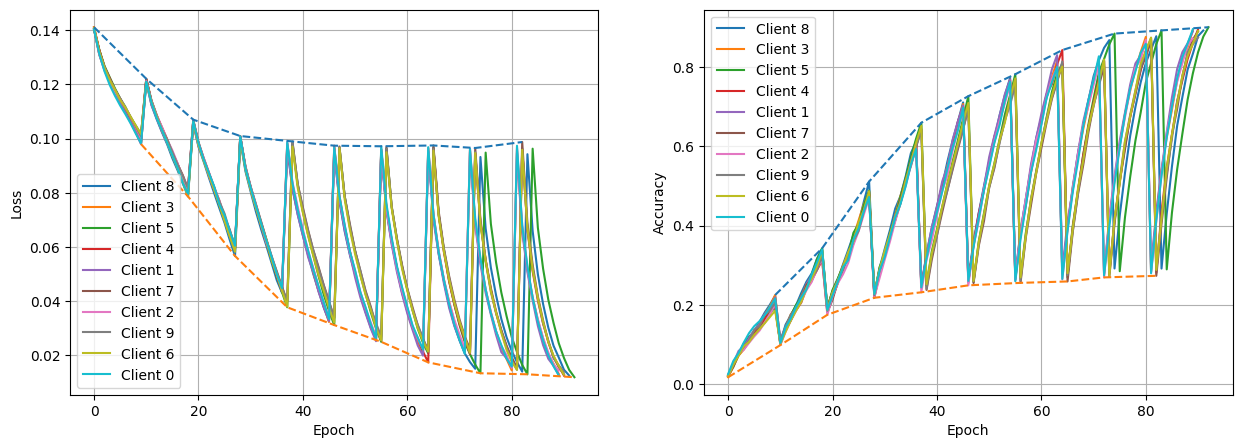

In [11]:
import matplotlib.pyplot as plt


def plot_metrics(client_metrics, rounds: int = 10):
    # client_metrics = strategy.client_metrics
    client_ids = list(client_metrics.keys())

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))

    round_max_losses: List[Tuple[int, float]] = []
    round_max_accuracy: List[Tuple[int, float]] = []
    round_min_losses: List[Tuple[int, float]] = []
    round_min_accuracy: List[Tuple[int, float]] = []

    for round in range(1, rounds+1):
        metrics_round = [(metrics.epoch, metrics.loss, metrics.accuracy) for metrics_list in client_metrics.values()
                       for metrics in metrics_list if metrics.round == round]
        if metrics_round:
            min_loss = min(metrics_round, key=lambda x: x[1])
            max_loss = max(metrics_round, key=lambda x: x[1])
            round_max_losses.append(max_loss)
            round_min_losses.append(min_loss)
            min_accuracy = min(metrics_round, key=lambda x: x[2])
            max_accuracy = max(metrics_round, key=lambda x: x[2])
            round_max_accuracy.append(max_accuracy)
            round_min_accuracy.append(min_accuracy)

    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        losses = [metric.loss for metric in client_metrics[cid]]
        axs[0].plot(epochs, losses, label=f"Client {cid}")

    max_epochs = [round_max[0] for round_max in round_max_losses]
    max_losses = [round_max[1] for round_max in round_max_losses]
    min_epochs = [round_min[0] for round_min in round_min_losses]
    min_losses = [round_min[1] for round_min in round_min_losses]
    axs[0].plot(max_epochs, max_losses, linestyle='dashed')
    axs[0].plot(min_epochs, min_losses, linestyle='dashed')

    axs[0].set_xlabel("Epoch")
    axs[0].set_ylabel("Loss")
    axs[0].legend()
    axs[0].grid()


    for cid in client_ids:
        epochs = [metric.epoch for metric in client_metrics[cid]]
        accuracies = [metric.accuracy for metric in client_metrics[cid]]
        axs[1].plot(epochs, accuracies, label=f"Client {cid}")

    max_epochs = [round_max[0] for round_max in round_max_accuracy]
    max_accuracies = [round_max[2] for round_max in round_max_accuracy]
    min_epochs = [round_min[0] for round_min in round_min_accuracy]
    min_accuracies = [round_min[2] for round_min in round_min_accuracy]
    axs[1].plot(max_epochs, max_accuracies, linestyle='dashed')
    axs[1].plot(min_epochs, min_accuracies, linestyle='dashed')

    axs[1].set_xlabel("Epoch")
    axs[1].set_ylabel("Accuracy")
    axs[1].legend()
    axs[1].grid()

    plt.show()

plot_metrics(strategy.client_metrics)

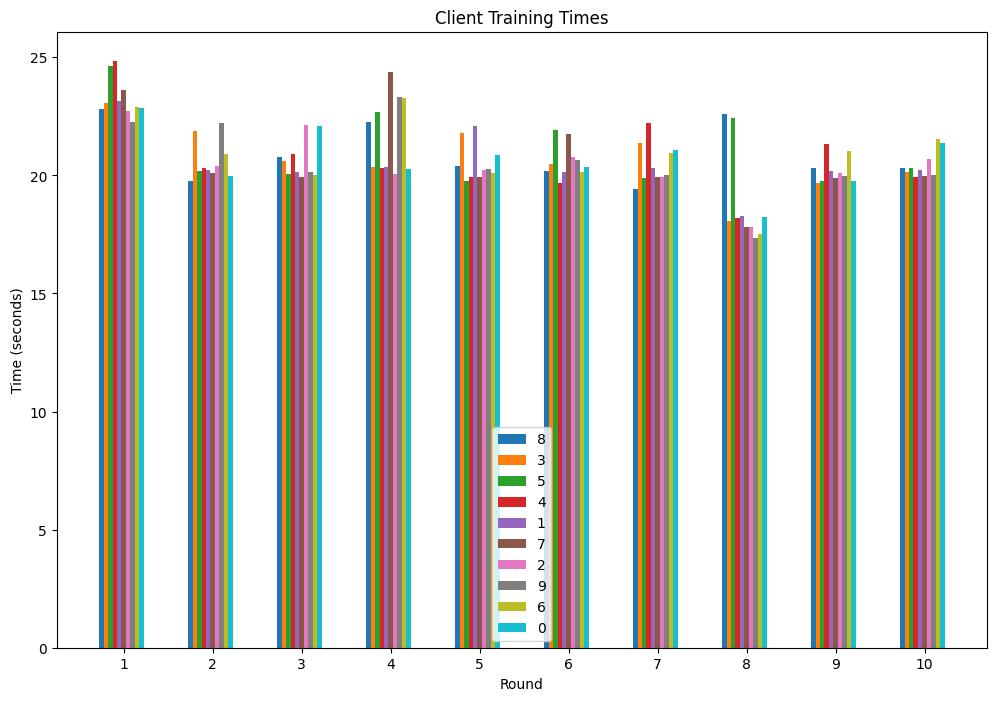

In [12]:
def plot_times(client_training_times):
    client_ids = list(client_training_times.keys())
    num_rounds = len(client_training_times[client_ids[0]])

    x = np.arange(num_rounds)  # Positions of the bars
    bar_width = 0.05 # Width of bars
    fig, ax = plt.subplots(figsize=(12, 8))

    for i, client_id in enumerate(client_ids):
        times = client_training_times[client_id]
        ax.bar(x + i * bar_width, times, bar_width, label=client_id)

    ax.set_xlabel("Round")
    ax.set_ylabel("Time (seconds)")
    ax.set_title("Client Training Times")
    ax.set_xticks(x + bar_width * round(len(client_ids) / 2))
    ax.set_xticklabels(np.arange(1, num_rounds + 1))
    ax.legend()

    plt.show()

plot_times(strategy.client_training_times)

In [13]:
for a in strategy.client_metrics:
    print(f"Client {a} metrics: {len(strategy.client_metrics[a])}")

Client 8 metrics: 92
Client 3 metrics: 90
Client 5 metrics: 93
Client 4 metrics: 91
Client 1 metrics: 90
Client 7 metrics: 91
Client 2 metrics: 90
Client 9 metrics: 91
Client 6 metrics: 91
Client 0 metrics: 90


In [14]:
class FlowerClient(fl.client.NumPyClient):
    def __init__(self, cid, net, trainloader, valloader):
        self.cid = cid
        self.net = net
        self.trainloader = trainloader
        self.valloader = valloader

    def get_parameters(self, config):
        print(f"[Client {self.cid}] get_parameters")
        return get_parameters(self.net)

    def fit(self, parameters, config):
        print(f"[Client {self.cid}] fit, config: {config}")
        set_parameters(self.net, parameters)
        start_time = time.time()  # Start time measurement
        metrics = train(self.net, self.trainloader, epochs=10)
        training_time = time.time() - start_time  # Calculate duration
        return get_parameters(self.net), len(self.trainloader), {"training_time": training_time, "metrics": json.dumps(metrics)}

    def evaluate(self, parameters, config):
        print(f"[Client {self.cid}] evaluate, config: {config}")
        set_parameters(self.net, parameters)
        loss, accuracy = test(self.net, self.valloader)
        print(f"Client {self.cid} loss {loss}")
        print(f"Client {self.cid} accuracy {accuracy}")
        return float(loss), len(self.valloader), {"accuracy": float(accuracy)}


def client_fn(cid) -> FlowerClient:
    net = Net().to(DEVICE) #Load Model from here
    trainloader = trainloaders[int(cid)]
    valloader = valloaders[int(cid)]
    return FlowerClient(cid, net, trainloader, valloader).to_client()

In [15]:
class FedAvgCustom(fl.server.strategy.FedAvg):
    def __init__(
        self,
        fraction_fit = 1.0,
        fraction_evaluate = 1.0,
        min_fit_clients = 2,
        min_evaluate_clients = 2,
        min_available_clients = 2,
    ):
        super().__init__(fraction_fit = fraction_fit, fraction_evaluate = fraction_evaluate, min_fit_clients = min_fit_clients, min_evaluate_clients = min_evaluate_clients, min_available_clients = min_available_clients)
        self.client_training_times: Dict[int, List[float]] = {}
        self.client_metrics: Dict[int, List[ClientMetrics]] = {}
        self.loss_extreme: Dict[int, Tuple[int, float, float]] = {}
        self.accuracy_extreme: Dict[int, Tuple[int, float, float]] = {}

    def parse_metrics(self, cid: int, server_round: int, metrics: str):
        client_data: List[ClientMetrics] = json.loads(metrics)
        data_store: List[ClientMetrics] = self.client_metrics.setdefault(cid, [])
        last_epoch: int = len(data_store)
        for data in client_data:
            data_store.append(ClientMetrics(last_epoch, data[1], data[2], round=server_round, cid=cid))
            last_epoch += 1

    def aggregate_fit(
        self,
        server_round: int,
        results: List[Tuple[ClientProxy, FitRes]],
        failures: List[Union[Tuple[ClientProxy, FitRes], BaseException]],
    ) -> Tuple[Optional[Parameters], Dict[str, Scalar]]:
        """Aggregate fit results using weighted average."""
        for client, fit_res in results:
            self.client_training_times.setdefault(client.cid, []).append(fit_res.metrics.get("training_time", 0))
            self.parse_metrics(client.cid, server_round, fit_res.metrics.get("metrics", None))
        weights_results = [
            (parameters_to_ndarrays(fit_res.parameters), fit_res.num_examples)
            for _, fit_res in results
        ]
        parameters_aggregated = ndarrays_to_parameters(aggregate(weights_results))
        metrics_aggregated = {}
        return parameters_aggregated, metrics_aggregated



In [16]:
strategy_fed_avg = FedAvgCustom()

fl.simulation.start_simulation(
    client_fn=client_fn,
    num_clients=10,
    config=fl.server.ServerConfig(num_rounds=10),
    client_resources=client_resources,
    strategy=strategy_fed_avg,
)

INFO :      Starting Flower simulation, config: num_rounds=10, no round_timeout
2024-07-25 18:31:21,684	INFO worker.py:1771 -- Started a local Ray instance.
INFO :      Flower VCE: Ray initialized with resources: {'node:__internal_head__': 1.0, 'CPU': 32.0, 'object_store_memory': 35348132659.0, 'node:127.0.0.1': 1.0, 'memory': 72478976205.0, 'GPU': 1.0, 'accelerator_type:RTX': 1.0}
INFO :      Optimize your simulation with Flower VCE: https://flower.ai/docs/framework/how-to-run-simulations.html
INFO :      Flower VCE: Resources for each Virtual Client: {'num_gpus': 0.125, 'num_cpus': 1}
INFO :      Flower VCE: Creating VirtualClientEngineActorPool with 8 actors
INFO :      [INIT]
INFO :      Requesting initial parameters from one random client
INFO :      Received initial parameters from one random client
INFO :      Evaluating initial global parameters
INFO :      
INFO :      [ROUND 1]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=3236) [Client 5] get_parameters
(ClientAppActor pid=3236) [Client 2] fit, config: {}
(ClientAppActor pid=3236) Epoch 0: train loss 0.143474, accuracy 0.013778
(ClientAppActor pid=3236) Epoch 1: train loss 0.135979, accuracy 0.035778
(ClientAppActor pid=38252) [Client 0] fit, config: {}
(ClientAppActor pid=3236) Epoch 2: train loss 0.129766, accuracy 0.060667
(ClientAppActor pid=38252) Epoch 0: train loss 0.143907, accuracy 0.012444
(ClientAppActor pid=3236) Epoch 3: train loss 0.124411, accuracy 0.080444
(ClientAppActor pid=39472) [Client 6] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=11248) Epoch 2: train loss 0.127975, accuracy 0.061556 [repeated 11x across cluster]
(ClientAppActor pid=23052) [Client 4] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=38252) Epoch 5: train loss 0.111812, accuracy 0.147778 [repeated 18x across cluster]
(ClientAppActor pid=3236) [Client 8] fit, config: {}
(ClientAppActor pid=23448) Epoch 5: train

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=38252) [Client 5] evaluate, config: {}
(ClientAppActor pid=38252) Epoch 9: train loss 0.094874, accuracy 0.242444
(ClientAppActor pid=38252) Client 5 loss 0.14357250595092774
(ClientAppActor pid=38252) Client 5 accuracy 0.042
(ClientAppActor pid=38252) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29940) Client 7 loss 0.1428873863220215 [repeated 3x across cluster]
(ClientAppActor pid=29940) Client 7 accuracy 0.038 [repeated 3x across cluster]
(ClientAppActor pid=3236) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=31424) Client 0 loss 0.14295354747772218 [repeated 4x across cluster]
(ClientAppActor pid=31424) Client 0 accuracy 0.042 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 2]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29940) [Client 0] fit, config: {}
(ClientAppActor pid=29940) [Client 1] evaluate, config: {}
(ClientAppActor pid=29940) Client 1 loss 0.14341172122955323 [repeated 2x across cluster]
(ClientAppActor pid=29940) Client 1 accuracy 0.044 [repeated 2x across cluster]
(ClientAppActor pid=29940) Epoch 0: train loss 0.124896, accuracy 0.086000
(ClientAppActor pid=31424) [Client 7] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=23052) Epoch 0: train loss 0.125007, accuracy 0.093333 [repeated 11x across cluster]
(ClientAppActor pid=11248) [Client 8] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=31424) Epoch 3: train loss 0.106445, accuracy 0.171778 [repeated 17x across cluster]
(ClientAppActor pid=23448) Epoch 6: train loss 0.093141, accuracy 0.250222 [repeated 20x across cluster]
(ClientAppActor pid=11248) Epoch 6: train loss 0.092837, accuracy 0.256222 [repeated 19x across cluster]
(ClientAppActor pid=29940) [Client 2] fit, config: {}
(C

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39472) [Client 2] evaluate, config: {}
(ClientAppActor pid=39472) Epoch 9: train loss 0.079463, accuracy 0.345778 [repeated 3x across cluster]
(ClientAppActor pid=39472) Client 2 loss 0.11079902124404907
(ClientAppActor pid=39472) Client 2 accuracy 0.166
(ClientAppActor pid=23052) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=23052) Client 3 loss 0.1073334903717041 [repeated 4x across cluster]
(ClientAppActor pid=23052) Client 3 accuracy 0.194 [repeated 4x across cluster]
(ClientAppActor pid=39472) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39472) Client 7 loss 0.1059434838294983 [repeated 4x across cluster]
(ClientAppActor pid=39472) Client 7 accuracy 0.164 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 3]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29940) [Client 1] fit, config: {}
(ClientAppActor pid=29940) [Client 5] evaluate, config: {}
(ClientAppActor pid=29940) Client 5 loss 0.11183172607421875
(ClientAppActor pid=29940) Client 5 accuracy 0.15
(ClientAppActor pid=29940) Epoch 0: train loss 0.106688, accuracy 0.181111
(ClientAppActor pid=38252) [Client 7] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=23448) Epoch 0: train loss 0.107483, accuracy 0.164889 [repeated 11x across cluster]
(ClientAppActor pid=11248) [Client 9] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29940) Epoch 5: train loss 0.076591, accuracy 0.358000 [repeated 18x across cluster]
(ClientAppActor pid=39472) Epoch 7: train loss 0.068095, accuracy 0.412444 [repeated 19x across cluster]
(ClientAppActor pid=29940) [Client 3] fit, config: {}
(ClientAppActor pid=39472) Epoch 9: train loss 0.058282, accuracy 0.483556 [repeated 16x across cluster]
(ClientAppActor pid=39472) [Client 4] fit, config: {}
(Client

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39472) Epoch 9: train loss 0.058665, accuracy 0.478889 [repeated 5x across cluster]
(ClientAppActor pid=39472) [Client 5] evaluate, config: {}
(ClientAppActor pid=39472) Client 5 loss 0.11110775661468505
(ClientAppActor pid=39472) Client 5 accuracy 0.218
(ClientAppActor pid=23448) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=23052) Client 3 loss 0.10631330251693726 [repeated 3x across cluster]
(ClientAppActor pid=23052) Client 3 accuracy 0.23 [repeated 3x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 4]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29940) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=39472) Client 8 loss 0.10789950323104859 [repeated 5x across cluster]
(ClientAppActor pid=39472) Client 8 accuracy 0.222 [repeated 5x across cluster]
(ClientAppActor pid=29940) [Client 2] fit, config: {}
(ClientAppActor pid=29940) Client 4 loss 0.1201630506515503
(ClientAppActor pid=29940) Client 4 accuracy 0.21
(ClientAppActor pid=29940) Epoch 0: train loss 0.101117, accuracy 0.211111
(ClientAppActor pid=38252) [Client 3] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=23448) Epoch 2: train loss 0.083456, accuracy 0.316222 [repeated 10x across cluster]
(ClientAppActor pid=23052) [Client 4] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=39472) Epoch 4: train loss 0.069665, accuracy 0.408444 [repeated 18x across cluster]
(ClientAppActor pid=11248) Epoch 5: train loss 0.064267, accuracy 0.450444 [repeated 20x across cluster]
(ClientAppActor pid=29

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23448) Epoch 9: train loss 0.041168, accuracy 0.627111 [repeated 5x across cluster]
(ClientAppActor pid=23448) [Client 8] evaluate, config: {}
(ClientAppActor pid=23448) Client 8 loss 0.11721349334716796
(ClientAppActor pid=23448) Client 8 accuracy 0.232
(ClientAppActor pid=23448) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=31424) Client 6 loss 0.125623797416687 [repeated 3x across cluster]
(ClientAppActor pid=31424) Client 6 accuracy 0.228 [repeated 3x across cluster]
(ClientAppActor pid=3236) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38252) Client 1 loss 0.11763190078735351 [repeated 4x across cluster]
(ClientAppActor pid=38252) Client 1 accuracy 0.262 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 5]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29940) [Client 2] fit, config: {}
(ClientAppActor pid=29940) [Client 9] evaluate, config: {}
(ClientAppActor pid=29940) Client 9 loss 0.12468909502029418 [repeated 2x across cluster]
(ClientAppActor pid=29940) Client 9 accuracy 0.206 [repeated 2x across cluster]
(ClientAppActor pid=29940) Epoch 0: train loss 0.098686, accuracy 0.232000
(ClientAppActor pid=23052) [Client 3] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=23052) Epoch 0: train loss 0.098308, accuracy 0.243333 [repeated 11x across cluster]
(ClientAppActor pid=39472) [Client 1] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=38252) Epoch 4: train loss 0.058748, accuracy 0.492444 [repeated 17x across cluster]
(ClientAppActor pid=31424) Epoch 4: train loss 0.058833, accuracy 0.492667 [repeated 19x across cluster]
(ClientAppActor pid=29940) Epoch 9: train loss 0.029576, accuracy 0.744444 [repeated 14x across cluster]
(ClientAppActor pid=29940) [Client 4] fit, config: {}
(C

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23448) [Client 0] evaluate, config: {}
(ClientAppActor pid=23448) Client 0 loss 0.12205655336380004
(ClientAppActor pid=23448) Client 0 accuracy 0.268
(ClientAppActor pid=23448) Epoch 9: train loss 0.031256, accuracy 0.711111
(ClientAppActor pid=23052) [Client 2] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=31424) Client 8 loss 0.12942515516281128 [repeated 3x across cluster]
(ClientAppActor pid=31424) Client 8 accuracy 0.23 [repeated 3x across cluster]
(ClientAppActor pid=38252) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=23448) Client 4 loss 0.14371404838562013 [repeated 4x across cluster]
(ClientAppActor pid=23448) Client 4 accuracy 0.222 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 6]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=31424) [Client 0] fit, config: {}
(ClientAppActor pid=31424) [Client 9] evaluate, config: {}
(ClientAppActor pid=31424) Client 9 loss 0.13808444690704347 [repeated 2x across cluster]
(ClientAppActor pid=31424) Client 9 accuracy 0.216 [repeated 2x across cluster]
(ClientAppActor pid=31424) Epoch 0: train loss 0.097969, accuracy 0.254667
(ClientAppActor pid=23052) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=23448) Epoch 0: train loss 0.097806, accuracy 0.255778 [repeated 11x across cluster]
(ClientAppActor pid=29940) [Client 6] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=23052) Epoch 3: train loss 0.058866, accuracy 0.482444 [repeated 18x across cluster]
(ClientAppActor pid=39472) Epoch 7: train loss 0.031222, accuracy 0.720889 [repeated 19x across cluster]
(ClientAppActor pid=31424) [Client 5] fit, config: {}
(ClientAppActor pid=23448) Epoch 7: train loss 0.032546, accuracy 0.700667 [repeated 18x across cluster]
(C

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=39472) Epoch 9: train loss 0.022820, accuracy 0.794667 [repeated 5x across cluster]
(ClientAppActor pid=39472) [Client 0] evaluate, config: {}
(ClientAppActor pid=39472) Client 0 loss 0.13293924331665039
(ClientAppActor pid=39472) Client 0 accuracy 0.254
(ClientAppActor pid=23448) [Client 6] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=23448) Client 6 loss 0.14746778964996338 [repeated 4x across cluster]
(ClientAppActor pid=23448) Client 6 accuracy 0.234 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 7]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=38252) [Client 3] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=38252) Client 3 loss 0.13645805263519287 [repeated 5x across cluster]
(ClientAppActor pid=38252) Client 3 accuracy 0.242 [repeated 5x across cluster]
(ClientAppActor pid=38252) [Client 3] fit, config: {}
(ClientAppActor pid=38252) Epoch 0: train loss 0.098674, accuracy 0.259333
(ClientAppActor pid=23052) [Client 1] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=23448) Epoch 0: train loss 0.099339, accuracy 0.250222 [repeated 8x across cluster]
(ClientAppActor pid=3236) [Client 9] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=31424) Epoch 4: train loss 0.044257, accuracy 0.605556 [repeated 20x across cluster]
(ClientAppActor pid=29940) Epoch 7: train loss 0.026168, accuracy 0.764667 [repeated 20x across cluster]
(ClientAppActor pid=39472) Epoch 7: train loss 0.026156, accuracy 0.763778 [repeated 17x across cluster]
(ClientAppActor pid=38252) [C

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=29940) Epoch 9: train loss 0.018399, accuracy 0.839556 [repeated 5x across cluster]
(ClientAppActor pid=29940) [Client 8] evaluate, config: {}
(ClientAppActor pid=29940) Client 8 loss 0.1542906150817871
(ClientAppActor pid=29940) Client 8 accuracy 0.222
(ClientAppActor pid=38252) [Client 0] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=11248) Client 3 loss 0.14672149181365968 [repeated 3x across cluster]
(ClientAppActor pid=11248) Client 3 accuracy 0.24 [repeated 3x across cluster]
(ClientAppActor pid=11248) [Client 4] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=11248) Client 4 loss 0.17026383781433105 [repeated 5x across cluster]
(ClientAppActor pid=11248) Client 4 accuracy 0.212 [repeated 5x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 8]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23448) [Client 2] fit, config: {}
(ClientAppActor pid=23448) [Client 5] evaluate, config: {}
(ClientAppActor pid=23448) Client 5 loss 0.1556588296890259
(ClientAppActor pid=23448) Client 5 accuracy 0.236
(ClientAppActor pid=23448) Epoch 0: train loss 0.098724, accuracy 0.257556
(ClientAppActor pid=3236) [Client 5] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=3236) Epoch 1: train loss 0.071996, accuracy 0.397333 [repeated 10x across cluster]
(ClientAppActor pid=31424) [Client 4] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=38252) Epoch 3: train loss 0.048389, accuracy 0.568000 [repeated 19x across cluster]
(ClientAppActor pid=3236) Epoch 6: train loss 0.024987, accuracy 0.781111 [repeated 19x across cluster]
(ClientAppActor pid=23448) [Client 0] fit, config: {}
(ClientAppActor pid=11248) Epoch 9: train loss 0.014291, accuracy 0.875556 [repeated 17x across cluster]
(ClientAppActor pid=11248) [Client 1] fit, config: {}
(ClientApp

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=11248) [Client 1] evaluate, config: {}
(ClientAppActor pid=11248) Client 1 loss 0.17314789485931398
(ClientAppActor pid=11248) Client 1 accuracy 0.246
(ClientAppActor pid=11248) Epoch 9: train loss 0.015326, accuracy 0.864222
(ClientAppActor pid=39472) [Client 5] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39472) Client 5 loss 0.16547442626953124 [repeated 4x across cluster]
(ClientAppActor pid=39472) Client 5 accuracy 0.242 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 9]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=23052) [Client 4] evaluate, config: {} [repeated 5x across cluster]
(ClientAppActor pid=23052) Client 4 loss 0.18133067607879638 [repeated 5x across cluster]
(ClientAppActor pid=23052) Client 4 accuracy 0.204 [repeated 5x across cluster]
(ClientAppActor pid=23052) [Client 4] fit, config: {}
(ClientAppActor pid=23052) Epoch 0: train loss 0.099129, accuracy 0.259333
(ClientAppActor pid=11248) [Client 8] fit, config: {} [repeated 4x across cluster]
(ClientAppActor pid=39472) Epoch 0: train loss 0.099041, accuracy 0.274444 [repeated 11x across cluster]
(ClientAppActor pid=3236) [Client 7] fit, config: {} [repeated 3x across cluster]
(ClientAppActor pid=23052) Epoch 5: train loss 0.027818, accuracy 0.754000 [repeated 18x across cluster]
(ClientAppActor pid=29940) Epoch 6: train loss 0.021961, accuracy 0.805333 [repeated 19x across cluster]
(ClientAppActor pid=23052) [Client 1] fit, config: {}
(ClientAppActor pid=38252) Epoch 9: train loss 0.012087, accuracy 0.897111 [rep

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=38252) Epoch 9: train loss 0.012627, accuracy 0.890444 [repeated 5x across cluster]
(ClientAppActor pid=38252) [Client 3] evaluate, config: {}
(ClientAppActor pid=38252) Client 3 loss 0.16347794723510742
(ClientAppActor pid=38252) Client 3 accuracy 0.226
(ClientAppActor pid=39472) [Client 9] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=23448) Client 8 loss 0.17438663291931153 [repeated 3x across cluster]
(ClientAppActor pid=23448) Client 8 accuracy 0.222 [repeated 3x across cluster]
(ClientAppActor pid=31424) [Client 7] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=29940) Client 1 loss 0.18286064624786377 [repeated 4x across cluster]
(ClientAppActor pid=29940) Client 1 accuracy 0.254 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [ROUND 10]
INFO :      configure_fit: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=3236) [Client 4] fit, config: {}
(ClientAppActor pid=3236) [Client 6] evaluate, config: {}
(ClientAppActor pid=3236) Client 6 loss 0.1842585563659668 [repeated 2x across cluster]
(ClientAppActor pid=3236) Client 6 accuracy 0.214 [repeated 2x across cluster]
(ClientAppActor pid=3236) Epoch 0: train loss 0.100483, accuracy 0.271556
(ClientAppActor pid=23052) [Client 6] fit, config: {} [repeated 5x across cluster]
(ClientAppActor pid=3236) Epoch 2: train loss 0.052635, accuracy 0.522889 [repeated 8x across cluster]
(ClientAppActor pid=29940) [Client 3] fit, config: {} [repeated 2x across cluster]
(ClientAppActor pid=3236) Epoch 5: train loss 0.024909, accuracy 0.773778 [repeated 21x across cluster]
(ClientAppActor pid=39472) Epoch 4: train loss 0.031043, accuracy 0.710444 [repeated 18x across cluster]
(ClientAppActor pid=39472) Epoch 6: train loss 0.018531, accuracy 0.829556 [repeated 17x across cluster]
(ClientAppActor pid=3236) [Client 9] fit, config: {}
(ClientAppAc

INFO :      aggregate_fit: received 10 results and 0 failures
INFO :      configure_evaluate: strategy sampled 10 clients (out of 10)


(ClientAppActor pid=38252) Epoch 9: train loss 0.008926, accuracy 0.928000 [repeated 5x across cluster]
(ClientAppActor pid=38252) [Client 7] evaluate, config: {}
(ClientAppActor pid=38252) Client 7 loss 0.17556881618499756
(ClientAppActor pid=38252) Client 7 accuracy 0.244
(ClientAppActor pid=3236) [Client 3] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=3236) Client 3 loss 0.172135085105896 [repeated 4x across cluster]
(ClientAppActor pid=3236) Client 3 accuracy 0.216 [repeated 4x across cluster]
(ClientAppActor pid=11248) [Client 1] evaluate, config: {} [repeated 4x across cluster]
(ClientAppActor pid=11248) Client 1 loss 0.19165705490112306 [repeated 4x across cluster]
(ClientAppActor pid=11248) Client 1 accuracy 0.242 [repeated 4x across cluster]


INFO :      aggregate_evaluate: received 10 results and 0 failures
INFO :      
INFO :      [SUMMARY]
INFO :      Run finished 10 round(s) in 639.65s
INFO :      	History (loss, distributed):
INFO :      		round 1: 0.1433672598838806
INFO :      		round 2: 0.11063096947669984
INFO :      		round 3: 0.1104101791858673
INFO :      		round 4: 0.11936303935050965
INFO :      		round 5: 0.13141112713813782
INFO :      		round 6: 0.1440706075668335
INFO :      		round 7: 0.1554052463531494
INFO :      		round 8: 0.16616258721351623
INFO :      		round 9: 0.17559976367950442
INFO :      		round 10: 0.18578992142677306
INFO :      


History (loss, distributed):
	round 1: 0.1433672598838806
	round 2: 0.11063096947669984
	round 3: 0.1104101791858673
	round 4: 0.11936303935050965
	round 5: 0.13141112713813782
	round 6: 0.1440706075668335
	round 7: 0.1554052463531494
	round 8: 0.16616258721351623
	round 9: 0.17559976367950442
	round 10: 0.18578992142677306

(ClientAppActor pid=23448) Client 8 loss 0.18562911987304687
(ClientAppActor pid=23448) Client 8 accuracy 0.196


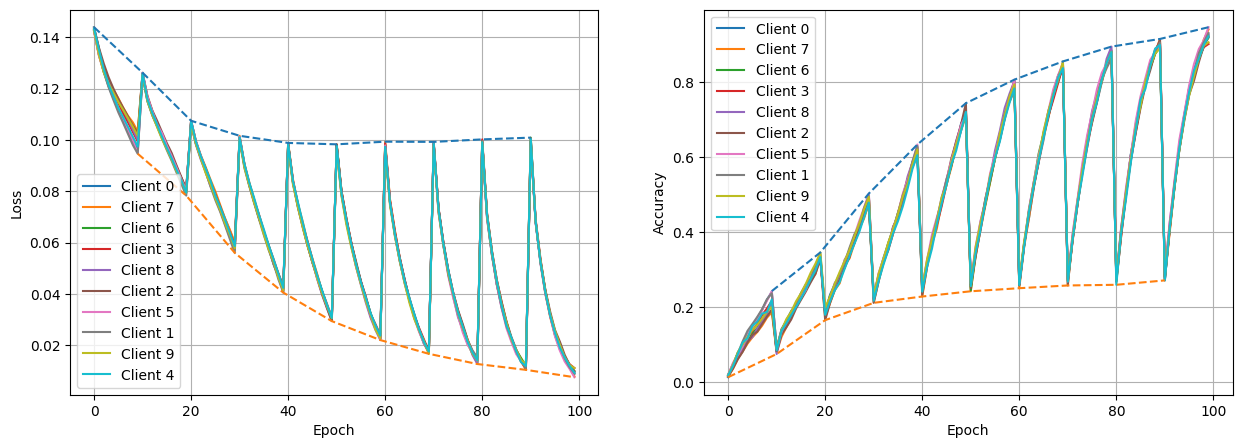

In [17]:
plot_metrics(strategy_fed_avg.client_metrics)

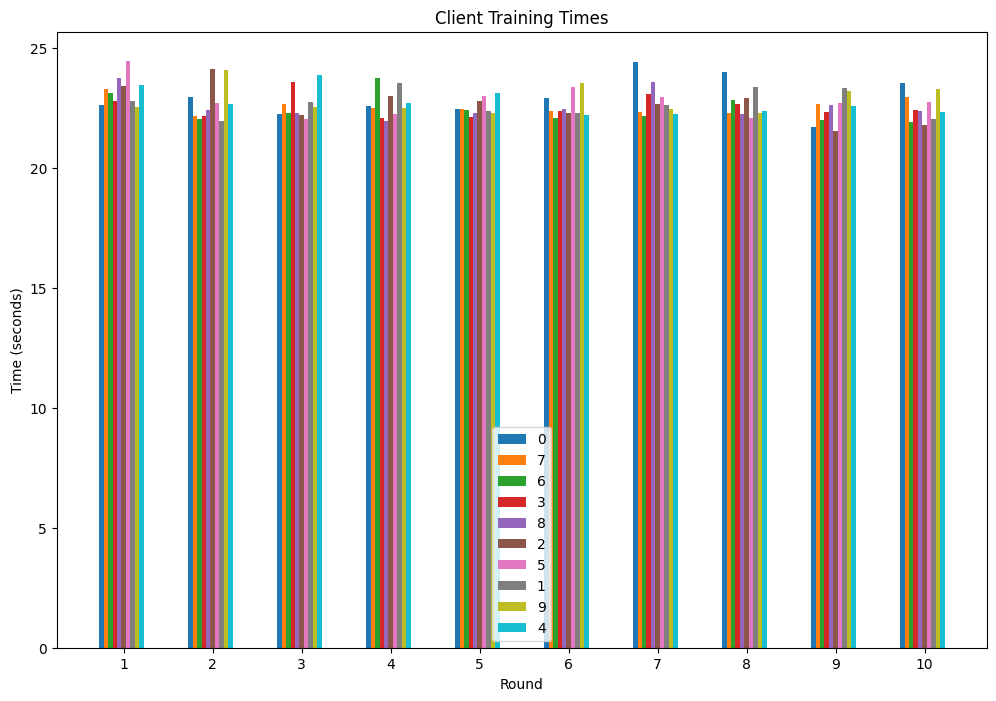

In [18]:
plot_times(strategy_fed_avg.client_training_times)